In [1]:
import os
import sys
import time
import yaml
import shutil
import argparse
import tarfile
import random
import tempfile
import subprocess

import torch
import pytorch_lightning as ptl
from pytorch_lightning import Trainer

import hypertune

import boda


In [2]:
print(torch.__version__)
print(ptl.__version__)

1.7.1
1.3.0


In [3]:
def main(args):
    data_module = getattr(boda.data, args['Main args'].data_module)
    model_module= getattr(boda.model, args['Main args'].model_module)
    graph_module= getattr(boda.graph, args['Main args'].graph_module)

    data = data_module(**vars(data_module.process_args(args)))
    model= model_module(**vars(model_module.process_args(args)))

    model.__class__ = type(
        'BODA_module',
        (model_module,graph_module),
        vars(graph_module.process_args(args))
    )

    trainer = Trainer.from_argparse_args(args['pl.Trainer'])
    os.makedirs(trainer.default_root_dir, exist_ok=True)
    
    trainer.fit(model, data)
    
    #_save_model(data_module, model_module, graph_module, 
    #            model, trainer, args)
    
    return data_module, model_module, graph_module, model, trainer, args

In [4]:
def _save_model(data_module, model_module, graph_module, 
                model, trainer, args):
    local_dir = args['pl.Trainer'].default_root_dir
    save_dict = {
        'data_module'  : data_module.__name__,
        'data_hparams' : data_module.process_args(args),
        'model_module' : model_module.__name__,
        'model_hparams': model_module.process_args(args),
        'graph_module' : graph_module.__name__,
        'graph_hparams': graph_module.process_args(args),
        'model_state_dict': model.state_dict(),
        'timestamp'    : time.strftime("%Y%m%d_%H%M%S"),
        'random_tag'   : random.randint(100000,999999)
    }
    torch.save(save_dict, os.path.join(local_dir,'torch_checkpoint.pt'))
    
    filename=f'model_artifacts__{save_dict["timestamp"]}__{save_dict["random_tag"]}.tar.gz'
    with tempfile.TemporaryDirectory() as tmpdirname:
        tmpdirname = '/tmp/output'
        with tarfile.open(os.path.join(tmpdirname,filename), 'w:gz') as tar:
            tar.add(local_dir,arcname='artifacts')

        if 'gs://' in args['Main args'].artifact_path:
            clound_target = os.path.join(args['Main args'].artifact_path,filename)
            subprocess.check_call(
                ['gsutil', 'cp', os.path.join(tmpdirname,filename), clound_target]
            )
        else:
            os.makedirs(args['Main args'].artifact_path, exist_ok=True)
            shutil.copy(os.path.join(tmpdirname,filename), args['Main args'].artifact_path)


In [5]:
def model_fn(model_dir):
    checkpoint = torch.load(os.path.join(model_dir,'torch_checkpoint.pt'))
    model_module = getattr(boda, checkpoint['model_module'])
    model        = model_module(**checkpoint['model_hparams'])
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f'Loaded model from {checkpoint["timestamp"]}')
    return model


# Process runtime arguments

## Command line args to use for testing

In [6]:
cmd_str = '--data_module BODA2_DataModule ' +\
            '--datafile_path  gs://syrgoth/data/BODA.MPRA.txt ' +\
            '--valid_pct  10 --test_pct  10 ' +\
            '--batch_size  1024 --padded_seq_len 600 --num_workers 1 ' +\
          '--model_module BassetEntropyVL ' +\
            '--n_linear_layers 3 --linear_channels 1000 ' +\
            '--n_outputs 3 ' +\
            '--kl_scale 3.0 ' +\
          '--graph_module CNNTransferLearning ' +\
            '--optimizer Adam ' +\
              '--lr 3e-4 --weight_decay 7e-6 --amsgrad True ' +\
            '--parent_weights gs://syrgoth/my-model.epoch_5-step_19885.pkl ' +\
            '--frozen_epochs 170 ' +\
          '--gpus 1 --min_epochs 280 --max_epochs 280 --precision 16 --default_root_dir /tmp/output/artifacts ' +\
          '--artifact_path gs://syrgoth/aip_ui_test '

'python /home/ubuntu/boda2/src/main.py ' + cmd_str

'python /home/ubuntu/boda2/src/main.py --data_module BODA2_DataModule --datafile_path  gs://syrgoth/data/BODA.MPRA.txt --valid_pct  10 --test_pct  10 --batch_size  1024 --padded_seq_len 600 --num_workers 1 --model_module BassetEntropyVL --n_linear_layers 3 --linear_channels 1000 --n_outputs 3 --kl_scale 3.0 --graph_module CNNTransferLearning --optimizer Adam --lr 3e-4 --weight_decay 7e-6 --amsgrad True --parent_weights gs://syrgoth/my-model.epoch_5-step_19885.pkl --frozen_epochs 170 --gpus 1 --min_epochs 280 --max_epochs 280 --precision 16 --default_root_dir /tmp/output/artifacts --artifact_path gs://syrgoth/aip_ui_test '

In [7]:
for i, value in enumerate(cmd_str.split()):
    if i % 2:
        print("="+value)
    else:
        print(value, end='')

--data_module=BODA2_DataModule
--datafile_path=gs://syrgoth/data/BODA.MPRA.txt
--valid_pct=10
--test_pct=10
--batch_size=1024
--padded_seq_len=600
--num_workers=1
--model_module=BassetEntropyVL
--n_linear_layers=3
--linear_channels=1000
--n_outputs=3
--kl_scale=3.0
--graph_module=CNNTransferLearning
--optimizer=Adam
--lr=3e-4
--weight_decay=7e-6
--amsgrad=True
--parent_weights=gs://syrgoth/my-model.epoch_5-step_19885.pkl
--frozen_epochs=170
--gpus=1
--min_epochs=280
--max_epochs=280
--precision=16
--default_root_dir=/tmp/output/artifacts
--artifact_path=gs://syrgoth/aip_ui_test


## Set base args for script

Basic arguments to identify which submodules are used and where data will be saved

In [8]:
parser = argparse.ArgumentParser(description="BODA trainer", add_help=False)
group = parser.add_argument_group('Main args')
group.add_argument('--data_module', type=str, required=True, help='BODA data module to process dataset.')
group.add_argument('--model_module',type=str, required=True, help='BODA model module to fit dataset.')
group.add_argument('--graph_module',type=str, required=True, help='BODA graph module to define computations.')
group.add_argument('--artifact_path', type=str, default='/opt/ml/checkpoints/', help='Path where model artifacts are deposited.')
group.add_argument('--pretrained_weights', type=str, help='Pretrained weights.')



_StoreAction(option_strings=['--pretrained_weights'], dest='pretrained_weights', nargs=None, const=None, default=None, type=<class 'str'>, choices=None, help='Pretrained weights.', metavar=None)

In [9]:
known_args, leftover_args = parser.parse_known_args(
    cmd_str.rstrip().split()
)

In [10]:
known_args

Namespace(artifact_path='gs://syrgoth/aip_ui_test', data_module='BODA2_DataModule', graph_module='CNNTransferLearning', model_module='BassetEntropyVL', pretrained_weights=None)

## Extract first-order submodule args

Get submodule specific arguments.

In [11]:
Data  = getattr(boda.data,  known_args.data_module)
Model = getattr(boda.model, known_args.model_module)
Graph = getattr(boda.graph, known_args.graph_module)

parser = Data.add_data_specific_args(parser)
parser = Model.add_model_specific_args(parser)
parser = Graph.add_graph_specific_args(parser)

known_args, leftover_args = parser.parse_known_args(
    cmd_str.rstrip().split()
)


In [12]:
known_args

Namespace(activity_columns=['K562', 'HepG2.neon', 'SKNSH'], artifact_path='gs://syrgoth/aip_ui_test', batch_size=1024, conv1_channels=300, conv1_kernel_size=19, conv2_channels=200, conv2_kernel_size=11, conv3_channels=200, conv3_kernel_size=7, criterion_reduction='mean', data_module='BODA2_DataModule', datafile_path='gs://syrgoth/data/BODA.MPRA.txt', dropout_p=0.3, frozen_epochs=170, graph_module='CNNTransferLearning', kl_scale=3.0, linear_channels=1000, model_module='BassetEntropyVL', mse_scale=1.0, n_linear_layers=3, n_outputs=3, num_workers=1, optimizer='Adam', padded_seq_len=600, parent_weights='gs://syrgoth/my-model.epoch_5-step_19885.pkl', pretrained_weights=None, scheduler=None, scheduler_interval='epoch', scheduler_monitor=None, sequence_column='nt.sequence', test_pct=10.0, use_batch_norm=True, use_weight_norm=False, valid_pct=10.0)

## Extract second-order submodule args

Get another set of submodule specific arguments based preliminary choices. (i.e., optional arguments for optimizer of choice)

In [13]:
parser = Data.add_conditional_args(parser, known_args)
parser = Model.add_conditional_args(parser, known_args)
parser = Graph.add_conditional_args(parser, known_args)

parser = Trainer.add_argparse_args(parser)
parser.add_argument('--help', '-h', action='help')
args = parser.parse_args(
    cmd_str.rstrip().split()
)

args = boda.common.utils.organize_args(parser, args)



In [14]:
args

{'positional arguments': Namespace(),
 'optional arguments': Namespace(help=None),
 'Main args': Namespace(artifact_path='gs://syrgoth/aip_ui_test', data_module='BODA2_DataModule', graph_module='CNNTransferLearning', model_module='BassetEntropyVL', pretrained_weights=None),
 'Data Module args': Namespace(activity_columns=['K562', 'HepG2.neon', 'SKNSH'], batch_size=1024, datafile_path='gs://syrgoth/data/BODA.MPRA.txt', num_workers=1, padded_seq_len=600, sequence_column='nt.sequence', test_pct=10.0, valid_pct=10.0),
 'Model Module args': Namespace(conv1_channels=300, conv1_kernel_size=19, conv2_channels=200, conv2_kernel_size=11, conv3_channels=200, conv3_kernel_size=7, criterion_reduction='mean', dropout_p=0.3, kl_scale=3.0, linear_channels=1000, mse_scale=1.0, n_linear_layers=3, n_outputs=3, use_batch_norm=True, use_weight_norm=False),
 'Graph Module args': Namespace(frozen_epochs=170, optimizer='Adam', parent_weights='gs://syrgoth/my-model.epoch_5-step_19885.pkl', scheduler=None, sche

# Run training
use modified `main` runner.

In [15]:
data_module, model_module, graph_module, model, trainer, args = main(args)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.


Padding sequences and converting to one-hot tensors...
10000/27719 sequences padded and tokenized...
20000/27719 sequences padded and tokenized...


Key conv1.conv.weight successfully matched
Key conv1.conv.bias successfully matched
Key conv1.bn_layer.weight successfully matched
Key conv1.bn_layer.bias successfully matched
Key conv1.bn_layer.running_mean successfully matched
Key conv1.bn_layer.running_var successfully matched
Key conv1.bn_layer.num_batches_tracked successfully matched
Key conv2.conv.weight successfully matched
Key conv2.conv.bias successfully matched
Key conv2.bn_layer.weight successfully matched
Key conv2.bn_layer.bias successfully matched
Key conv2.bn_layer.running_mean successfully matched
Key conv2.bn_layer.running_var successfully matched
Key conv2.bn_layer.num_batches_tracked successfully matched
Key conv3.conv.weight successfully matched
Key conv3.conv.bias successfully matched
Key conv3.bn_layer.weight successfully matched
Key conv3.bn_layer.bias successfully matched
Key conv3.bn_layer.running_mean successfully matched
Key conv3.bn_layer.running_var successfully matched
Key conv3.bn_layer.num_batches_tracke

Found 5576903 parameters


Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



-----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.40580 | harmonic_mean_loss: 1.42788 | prediction_mean_pearson: -0.03301 | entropy_mean_pearson: 0.01991 |
-----------------------------------------------------------------------------------------------------------------------------------



/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2398: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

starting epoch 0


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.37587 | harmonic_mean_loss: 1.32888 | prediction_mean_pearson: 0.22992 | entropy_mean_pearson: 0.01460 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 1


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.35490 | harmonic_mean_loss: 1.24659 | prediction_mean_pearson: 0.26655 | entropy_mean_pearson: 0.03945 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 2


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.32811 | harmonic_mean_loss: 1.15059 | prediction_mean_pearson: 0.28153 | entropy_mean_pearson: 0.05474 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 3


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.33206 | harmonic_mean_loss: 1.16740 | prediction_mean_pearson: 0.28041 | entropy_mean_pearson: 0.04745 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 4


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.32165 | harmonic_mean_loss: 1.11914 | prediction_mean_pearson: 0.28781 | entropy_mean_pearson: 0.01277 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 5


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.32079 | harmonic_mean_loss: 1.11819 | prediction_mean_pearson: 0.29213 | entropy_mean_pearson: 0.04152 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 6


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.32040 | harmonic_mean_loss: 1.11363 | prediction_mean_pearson: 0.29951 | entropy_mean_pearson: 0.01674 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 7


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.32148 | harmonic_mean_loss: 1.11791 | prediction_mean_pearson: 0.30145 | entropy_mean_pearson: 0.03567 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 8


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.32070 | harmonic_mean_loss: 1.12480 | prediction_mean_pearson: 0.29717 | entropy_mean_pearson: 0.05400 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 9


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.32163 | harmonic_mean_loss: 1.12287 | prediction_mean_pearson: 0.29636 | entropy_mean_pearson: 0.06036 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 10


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.32008 | harmonic_mean_loss: 1.11594 | prediction_mean_pearson: 0.30138 | entropy_mean_pearson: 0.05481 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 11


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31684 | harmonic_mean_loss: 1.10539 | prediction_mean_pearson: 0.30699 | entropy_mean_pearson: 0.04782 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 12


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31891 | harmonic_mean_loss: 1.11140 | prediction_mean_pearson: 0.30026 | entropy_mean_pearson: 0.04903 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 13


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31776 | harmonic_mean_loss: 1.10915 | prediction_mean_pearson: 0.30885 | entropy_mean_pearson: 0.06064 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 14


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31498 | harmonic_mean_loss: 1.09747 | prediction_mean_pearson: 0.30998 | entropy_mean_pearson: 0.06163 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 15


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.32081 | harmonic_mean_loss: 1.12009 | prediction_mean_pearson: 0.30740 | entropy_mean_pearson: 0.06595 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 16


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31744 | harmonic_mean_loss: 1.10657 | prediction_mean_pearson: 0.30663 | entropy_mean_pearson: 0.07465 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 17


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31590 | harmonic_mean_loss: 1.10005 | prediction_mean_pearson: 0.31085 | entropy_mean_pearson: 0.07308 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 18


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31598 | harmonic_mean_loss: 1.09956 | prediction_mean_pearson: 0.30987 | entropy_mean_pearson: 0.06451 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 19


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31866 | harmonic_mean_loss: 1.11173 | prediction_mean_pearson: 0.31146 | entropy_mean_pearson: 0.06809 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 20


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31822 | harmonic_mean_loss: 1.10251 | prediction_mean_pearson: 0.31465 | entropy_mean_pearson: 0.04950 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 21


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31697 | harmonic_mean_loss: 1.10362 | prediction_mean_pearson: 0.30575 | entropy_mean_pearson: 0.05547 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 22


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.32080 | harmonic_mean_loss: 1.11650 | prediction_mean_pearson: 0.30811 | entropy_mean_pearson: 0.07330 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 23


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31478 | harmonic_mean_loss: 1.09725 | prediction_mean_pearson: 0.30809 | entropy_mean_pearson: 0.06584 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 24


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31408 | harmonic_mean_loss: 1.09455 | prediction_mean_pearson: 0.31340 | entropy_mean_pearson: 0.07044 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 25


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31365 | harmonic_mean_loss: 1.09275 | prediction_mean_pearson: 0.31500 | entropy_mean_pearson: 0.06681 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 26


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31526 | harmonic_mean_loss: 1.09612 | prediction_mean_pearson: 0.31342 | entropy_mean_pearson: 0.06335 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 27


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31465 | harmonic_mean_loss: 1.09732 | prediction_mean_pearson: 0.31435 | entropy_mean_pearson: 0.06928 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 28


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31411 | harmonic_mean_loss: 1.09352 | prediction_mean_pearson: 0.31477 | entropy_mean_pearson: 0.06339 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 29


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31404 | harmonic_mean_loss: 1.09282 | prediction_mean_pearson: 0.31283 | entropy_mean_pearson: 0.05815 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 30


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31426 | harmonic_mean_loss: 1.09520 | prediction_mean_pearson: 0.31175 | entropy_mean_pearson: 0.07089 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 31


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31548 | harmonic_mean_loss: 1.09906 | prediction_mean_pearson: 0.31398 | entropy_mean_pearson: 0.07365 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 32


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31439 | harmonic_mean_loss: 1.09537 | prediction_mean_pearson: 0.31246 | entropy_mean_pearson: 0.07154 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 33


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31439 | harmonic_mean_loss: 1.09583 | prediction_mean_pearson: 0.30980 | entropy_mean_pearson: 0.07750 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 34


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31432 | harmonic_mean_loss: 1.09669 | prediction_mean_pearson: 0.31387 | entropy_mean_pearson: 0.07641 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 35


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31781 | harmonic_mean_loss: 1.10338 | prediction_mean_pearson: 0.31230 | entropy_mean_pearson: 0.05751 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 36


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31376 | harmonic_mean_loss: 1.09303 | prediction_mean_pearson: 0.31555 | entropy_mean_pearson: 0.06504 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 37


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.32219 | harmonic_mean_loss: 1.12652 | prediction_mean_pearson: 0.30414 | entropy_mean_pearson: 0.08075 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 38


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31339 | harmonic_mean_loss: 1.09111 | prediction_mean_pearson: 0.31565 | entropy_mean_pearson: 0.08076 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 39


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31328 | harmonic_mean_loss: 1.09160 | prediction_mean_pearson: 0.31457 | entropy_mean_pearson: 0.07622 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 40


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31439 | harmonic_mean_loss: 1.09304 | prediction_mean_pearson: 0.31516 | entropy_mean_pearson: 0.07001 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 41


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31506 | harmonic_mean_loss: 1.09680 | prediction_mean_pearson: 0.31220 | entropy_mean_pearson: 0.08227 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 42


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31497 | harmonic_mean_loss: 1.09825 | prediction_mean_pearson: 0.31487 | entropy_mean_pearson: 0.07580 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 43


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31600 | harmonic_mean_loss: 1.10096 | prediction_mean_pearson: 0.31218 | entropy_mean_pearson: 0.07708 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 44


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31443 | harmonic_mean_loss: 1.09494 | prediction_mean_pearson: 0.31752 | entropy_mean_pearson: 0.07450 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 45


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31301 | harmonic_mean_loss: 1.08939 | prediction_mean_pearson: 0.31723 | entropy_mean_pearson: 0.07804 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 46


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31496 | harmonic_mean_loss: 1.09690 | prediction_mean_pearson: 0.31151 | entropy_mean_pearson: 0.08038 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 47


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31350 | harmonic_mean_loss: 1.09105 | prediction_mean_pearson: 0.31656 | entropy_mean_pearson: 0.08008 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 48


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31334 | harmonic_mean_loss: 1.09046 | prediction_mean_pearson: 0.31653 | entropy_mean_pearson: 0.07650 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 49


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31709 | harmonic_mean_loss: 1.10459 | prediction_mean_pearson: 0.31471 | entropy_mean_pearson: 0.08238 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 50


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31394 | harmonic_mean_loss: 1.09273 | prediction_mean_pearson: 0.31565 | entropy_mean_pearson: 0.08206 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 51


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31276 | harmonic_mean_loss: 1.08897 | prediction_mean_pearson: 0.31843 | entropy_mean_pearson: 0.08470 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 52


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31699 | harmonic_mean_loss: 1.10266 | prediction_mean_pearson: 0.31604 | entropy_mean_pearson: 0.08070 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 53


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31435 | harmonic_mean_loss: 1.09431 | prediction_mean_pearson: 0.31380 | entropy_mean_pearson: 0.08482 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 54


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31531 | harmonic_mean_loss: 1.09922 | prediction_mean_pearson: 0.31558 | entropy_mean_pearson: 0.08232 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 55


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31409 | harmonic_mean_loss: 1.09319 | prediction_mean_pearson: 0.31175 | entropy_mean_pearson: 0.08247 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 56


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31776 | harmonic_mean_loss: 1.10543 | prediction_mean_pearson: 0.31166 | entropy_mean_pearson: 0.07916 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 57


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31703 | harmonic_mean_loss: 1.10143 | prediction_mean_pearson: 0.31030 | entropy_mean_pearson: 0.07857 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 58


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31423 | harmonic_mean_loss: 1.09376 | prediction_mean_pearson: 0.31246 | entropy_mean_pearson: 0.07434 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 59


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31396 | harmonic_mean_loss: 1.09427 | prediction_mean_pearson: 0.31379 | entropy_mean_pearson: 0.08373 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 60


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31402 | harmonic_mean_loss: 1.09272 | prediction_mean_pearson: 0.31349 | entropy_mean_pearson: 0.06769 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 61


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31549 | harmonic_mean_loss: 1.09860 | prediction_mean_pearson: 0.31040 | entropy_mean_pearson: 0.07601 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 62


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31529 | harmonic_mean_loss: 1.09826 | prediction_mean_pearson: 0.30639 | entropy_mean_pearson: 0.08205 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 63


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.32099 | harmonic_mean_loss: 1.12059 | prediction_mean_pearson: 0.29975 | entropy_mean_pearson: 0.06932 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 64


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31484 | harmonic_mean_loss: 1.09630 | prediction_mean_pearson: 0.31560 | entropy_mean_pearson: 0.07511 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 65


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31423 | harmonic_mean_loss: 1.09447 | prediction_mean_pearson: 0.31562 | entropy_mean_pearson: 0.07530 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 66


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.32296 | harmonic_mean_loss: 1.12308 | prediction_mean_pearson: 0.30629 | entropy_mean_pearson: 0.06686 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 67


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31498 | harmonic_mean_loss: 1.09592 | prediction_mean_pearson: 0.31330 | entropy_mean_pearson: 0.07026 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 68


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31344 | harmonic_mean_loss: 1.09113 | prediction_mean_pearson: 0.31806 | entropy_mean_pearson: 0.06988 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 69


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31430 | harmonic_mean_loss: 1.09316 | prediction_mean_pearson: 0.31104 | entropy_mean_pearson: 0.07244 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 70


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31334 | harmonic_mean_loss: 1.08975 | prediction_mean_pearson: 0.31669 | entropy_mean_pearson: 0.07052 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 71


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31461 | harmonic_mean_loss: 1.09605 | prediction_mean_pearson: 0.31264 | entropy_mean_pearson: 0.07209 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 72


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31352 | harmonic_mean_loss: 1.09144 | prediction_mean_pearson: 0.31583 | entropy_mean_pearson: 0.07639 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 73


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31621 | harmonic_mean_loss: 1.09992 | prediction_mean_pearson: 0.30822 | entropy_mean_pearson: 0.07028 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 74


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31558 | harmonic_mean_loss: 1.09965 | prediction_mean_pearson: 0.30926 | entropy_mean_pearson: 0.07370 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 75


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31923 | harmonic_mean_loss: 1.11367 | prediction_mean_pearson: 0.30925 | entropy_mean_pearson: 0.07476 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 76


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31479 | harmonic_mean_loss: 1.09525 | prediction_mean_pearson: 0.31145 | entropy_mean_pearson: 0.07488 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 77


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.32056 | harmonic_mean_loss: 1.11657 | prediction_mean_pearson: 0.31012 | entropy_mean_pearson: 0.07946 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 78


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31553 | harmonic_mean_loss: 1.09845 | prediction_mean_pearson: 0.31769 | entropy_mean_pearson: 0.07363 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 79


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31880 | harmonic_mean_loss: 1.10884 | prediction_mean_pearson: 0.30776 | entropy_mean_pearson: 0.07209 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 80


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31492 | harmonic_mean_loss: 1.09523 | prediction_mean_pearson: 0.31495 | entropy_mean_pearson: 0.07539 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 81


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31371 | harmonic_mean_loss: 1.09175 | prediction_mean_pearson: 0.31407 | entropy_mean_pearson: 0.07437 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 82


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31556 | harmonic_mean_loss: 1.09889 | prediction_mean_pearson: 0.31199 | entropy_mean_pearson: 0.07809 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 83


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31592 | harmonic_mean_loss: 1.10017 | prediction_mean_pearson: 0.30998 | entropy_mean_pearson: 0.06801 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 84


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31367 | harmonic_mean_loss: 1.09106 | prediction_mean_pearson: 0.31433 | entropy_mean_pearson: 0.07139 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 85


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31791 | harmonic_mean_loss: 1.10646 | prediction_mean_pearson: 0.31100 | entropy_mean_pearson: 0.07370 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 86


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31289 | harmonic_mean_loss: 1.08894 | prediction_mean_pearson: 0.31664 | entropy_mean_pearson: 0.08157 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 87


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31502 | harmonic_mean_loss: 1.09588 | prediction_mean_pearson: 0.30891 | entropy_mean_pearson: 0.07168 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 88


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31464 | harmonic_mean_loss: 1.09465 | prediction_mean_pearson: 0.31099 | entropy_mean_pearson: 0.06729 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 89


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31727 | harmonic_mean_loss: 1.10331 | prediction_mean_pearson: 0.30621 | entropy_mean_pearson: 0.07066 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 90


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31409 | harmonic_mean_loss: 1.09260 | prediction_mean_pearson: 0.31135 | entropy_mean_pearson: 0.07346 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 91


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31849 | harmonic_mean_loss: 1.10976 | prediction_mean_pearson: 0.30505 | entropy_mean_pearson: 0.07491 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 92


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31495 | harmonic_mean_loss: 1.09531 | prediction_mean_pearson: 0.30639 | entropy_mean_pearson: 0.07916 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 93


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31436 | harmonic_mean_loss: 1.09331 | prediction_mean_pearson: 0.31087 | entropy_mean_pearson: 0.07386 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 94


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31442 | harmonic_mean_loss: 1.09427 | prediction_mean_pearson: 0.30941 | entropy_mean_pearson: 0.06691 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 95


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31685 | harmonic_mean_loss: 1.10202 | prediction_mean_pearson: 0.30596 | entropy_mean_pearson: 0.07322 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 96


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31594 | harmonic_mean_loss: 1.09906 | prediction_mean_pearson: 0.30317 | entropy_mean_pearson: 0.06917 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 97


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31448 | harmonic_mean_loss: 1.09477 | prediction_mean_pearson: 0.30829 | entropy_mean_pearson: 0.07105 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 98


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31712 | harmonic_mean_loss: 1.10479 | prediction_mean_pearson: 0.30763 | entropy_mean_pearson: 0.07109 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 99


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31843 | harmonic_mean_loss: 1.10769 | prediction_mean_pearson: 0.30619 | entropy_mean_pearson: 0.07269 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 100


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31374 | harmonic_mean_loss: 1.09080 | prediction_mean_pearson: 0.31346 | entropy_mean_pearson: 0.07667 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 101


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31442 | harmonic_mean_loss: 1.09343 | prediction_mean_pearson: 0.31399 | entropy_mean_pearson: 0.07739 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 102


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31484 | harmonic_mean_loss: 1.09511 | prediction_mean_pearson: 0.30938 | entropy_mean_pearson: 0.06868 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 103


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31509 | harmonic_mean_loss: 1.09791 | prediction_mean_pearson: 0.31091 | entropy_mean_pearson: 0.07449 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 104


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31482 | harmonic_mean_loss: 1.09505 | prediction_mean_pearson: 0.31070 | entropy_mean_pearson: 0.06999 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 105


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31934 | harmonic_mean_loss: 1.11164 | prediction_mean_pearson: 0.30247 | entropy_mean_pearson: 0.07232 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 106


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31471 | harmonic_mean_loss: 1.09547 | prediction_mean_pearson: 0.30782 | entropy_mean_pearson: 0.07551 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 107


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31362 | harmonic_mean_loss: 1.09040 | prediction_mean_pearson: 0.31374 | entropy_mean_pearson: 0.06396 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 108


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31573 | harmonic_mean_loss: 1.09756 | prediction_mean_pearson: 0.30484 | entropy_mean_pearson: 0.06982 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 109


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31852 | harmonic_mean_loss: 1.10806 | prediction_mean_pearson: 0.30731 | entropy_mean_pearson: 0.06616 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 110


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31514 | harmonic_mean_loss: 1.09573 | prediction_mean_pearson: 0.30917 | entropy_mean_pearson: 0.07028 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 111


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31517 | harmonic_mean_loss: 1.09553 | prediction_mean_pearson: 0.30624 | entropy_mean_pearson: 0.06521 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 112


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31858 | harmonic_mean_loss: 1.10693 | prediction_mean_pearson: 0.30529 | entropy_mean_pearson: 0.06654 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 113


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31550 | harmonic_mean_loss: 1.09794 | prediction_mean_pearson: 0.31012 | entropy_mean_pearson: 0.06970 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 114


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31408 | harmonic_mean_loss: 1.09190 | prediction_mean_pearson: 0.31649 | entropy_mean_pearson: 0.07321 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 115


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31551 | harmonic_mean_loss: 1.09693 | prediction_mean_pearson: 0.30597 | entropy_mean_pearson: 0.07011 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 116


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31332 | harmonic_mean_loss: 1.08981 | prediction_mean_pearson: 0.31604 | entropy_mean_pearson: 0.07219 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 117


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31547 | harmonic_mean_loss: 1.09619 | prediction_mean_pearson: 0.30992 | entropy_mean_pearson: 0.06953 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 118


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31320 | harmonic_mean_loss: 1.08948 | prediction_mean_pearson: 0.31456 | entropy_mean_pearson: 0.06865 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 119


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31545 | harmonic_mean_loss: 1.09714 | prediction_mean_pearson: 0.30964 | entropy_mean_pearson: 0.07388 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 120


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31592 | harmonic_mean_loss: 1.09877 | prediction_mean_pearson: 0.30943 | entropy_mean_pearson: 0.06647 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 121


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31387 | harmonic_mean_loss: 1.09139 | prediction_mean_pearson: 0.31291 | entropy_mean_pearson: 0.07144 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 122


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.32055 | harmonic_mean_loss: 1.11492 | prediction_mean_pearson: 0.30207 | entropy_mean_pearson: 0.05364 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 123


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31319 | harmonic_mean_loss: 1.08934 | prediction_mean_pearson: 0.31665 | entropy_mean_pearson: 0.06938 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 124


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31721 | harmonic_mean_loss: 1.10400 | prediction_mean_pearson: 0.30828 | entropy_mean_pearson: 0.06419 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 125


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.32094 | harmonic_mean_loss: 1.11903 | prediction_mean_pearson: 0.30449 | entropy_mean_pearson: 0.06912 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 126


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31485 | harmonic_mean_loss: 1.09476 | prediction_mean_pearson: 0.30750 | entropy_mean_pearson: 0.06658 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 127


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31384 | harmonic_mean_loss: 1.09082 | prediction_mean_pearson: 0.31425 | entropy_mean_pearson: 0.06650 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 128


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31420 | harmonic_mean_loss: 1.09184 | prediction_mean_pearson: 0.31260 | entropy_mean_pearson: 0.06582 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 129


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31566 | harmonic_mean_loss: 1.09631 | prediction_mean_pearson: 0.30892 | entropy_mean_pearson: 0.06240 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 130


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31567 | harmonic_mean_loss: 1.09824 | prediction_mean_pearson: 0.30884 | entropy_mean_pearson: 0.07319 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 131


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31838 | harmonic_mean_loss: 1.10657 | prediction_mean_pearson: 0.30256 | entropy_mean_pearson: 0.06887 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 132


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31694 | harmonic_mean_loss: 1.10186 | prediction_mean_pearson: 0.30755 | entropy_mean_pearson: 0.07282 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 133


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31481 | harmonic_mean_loss: 1.09516 | prediction_mean_pearson: 0.31114 | entropy_mean_pearson: 0.06755 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 134


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31504 | harmonic_mean_loss: 1.09587 | prediction_mean_pearson: 0.30617 | entropy_mean_pearson: 0.06616 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 135


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31459 | harmonic_mean_loss: 1.09420 | prediction_mean_pearson: 0.30995 | entropy_mean_pearson: 0.07009 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 136


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31483 | harmonic_mean_loss: 1.09513 | prediction_mean_pearson: 0.30756 | entropy_mean_pearson: 0.06544 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 137


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31790 | harmonic_mean_loss: 1.10548 | prediction_mean_pearson: 0.30727 | entropy_mean_pearson: 0.07015 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 138


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31461 | harmonic_mean_loss: 1.09452 | prediction_mean_pearson: 0.30941 | entropy_mean_pearson: 0.06761 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 139


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31577 | harmonic_mean_loss: 1.09826 | prediction_mean_pearson: 0.31188 | entropy_mean_pearson: 0.07477 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 140


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31455 | harmonic_mean_loss: 1.09380 | prediction_mean_pearson: 0.30994 | entropy_mean_pearson: 0.06809 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 141


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31992 | harmonic_mean_loss: 1.11301 | prediction_mean_pearson: 0.30664 | entropy_mean_pearson: 0.06394 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 142


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31553 | harmonic_mean_loss: 1.09830 | prediction_mean_pearson: 0.30564 | entropy_mean_pearson: 0.06371 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 143


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31418 | harmonic_mean_loss: 1.09310 | prediction_mean_pearson: 0.31002 | entropy_mean_pearson: 0.07468 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 144


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.32148 | harmonic_mean_loss: 1.11587 | prediction_mean_pearson: 0.30297 | entropy_mean_pearson: 0.06932 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 145


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31746 | harmonic_mean_loss: 1.10473 | prediction_mean_pearson: 0.30229 | entropy_mean_pearson: 0.06951 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 146


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31711 | harmonic_mean_loss: 1.10440 | prediction_mean_pearson: 0.30275 | entropy_mean_pearson: 0.06782 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 147


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31467 | harmonic_mean_loss: 1.09508 | prediction_mean_pearson: 0.30824 | entropy_mean_pearson: 0.06438 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 148


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31418 | harmonic_mean_loss: 1.09340 | prediction_mean_pearson: 0.31244 | entropy_mean_pearson: 0.06848 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 149


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31416 | harmonic_mean_loss: 1.09396 | prediction_mean_pearson: 0.31275 | entropy_mean_pearson: 0.07180 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 150


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.32783 | harmonic_mean_loss: 1.14311 | prediction_mean_pearson: 0.29701 | entropy_mean_pearson: 0.06206 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 151


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.32023 | harmonic_mean_loss: 1.11296 | prediction_mean_pearson: 0.30709 | entropy_mean_pearson: 0.06414 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 152


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31436 | harmonic_mean_loss: 1.09407 | prediction_mean_pearson: 0.30999 | entropy_mean_pearson: 0.06871 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 153


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31630 | harmonic_mean_loss: 1.10067 | prediction_mean_pearson: 0.30637 | entropy_mean_pearson: 0.06315 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 154


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31733 | harmonic_mean_loss: 1.10448 | prediction_mean_pearson: 0.30186 | entropy_mean_pearson: 0.06989 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 155


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.32213 | harmonic_mean_loss: 1.12510 | prediction_mean_pearson: 0.30660 | entropy_mean_pearson: 0.06939 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 156


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31603 | harmonic_mean_loss: 1.09995 | prediction_mean_pearson: 0.30108 | entropy_mean_pearson: 0.06643 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 157


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31871 | harmonic_mean_loss: 1.10602 | prediction_mean_pearson: 0.30440 | entropy_mean_pearson: 0.06595 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 158


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31627 | harmonic_mean_loss: 1.10018 | prediction_mean_pearson: 0.30265 | entropy_mean_pearson: 0.06814 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 159


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31421 | harmonic_mean_loss: 1.09270 | prediction_mean_pearson: 0.31125 | entropy_mean_pearson: 0.06763 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 160


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31536 | harmonic_mean_loss: 1.09630 | prediction_mean_pearson: 0.30522 | entropy_mean_pearson: 0.06565 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 161


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31693 | harmonic_mean_loss: 1.10124 | prediction_mean_pearson: 0.30993 | entropy_mean_pearson: 0.06032 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 162


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31668 | harmonic_mean_loss: 1.10268 | prediction_mean_pearson: 0.30286 | entropy_mean_pearson: 0.06211 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 163


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.33109 | harmonic_mean_loss: 1.15864 | prediction_mean_pearson: 0.29635 | entropy_mean_pearson: 0.06973 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 164


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.32176 | harmonic_mean_loss: 1.11528 | prediction_mean_pearson: 0.30161 | entropy_mean_pearson: 0.05675 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 165


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31816 | harmonic_mean_loss: 1.10391 | prediction_mean_pearson: 0.30454 | entropy_mean_pearson: 0.06315 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 166


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31561 | harmonic_mean_loss: 1.09709 | prediction_mean_pearson: 0.30570 | entropy_mean_pearson: 0.06749 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 167


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31573 | harmonic_mean_loss: 1.09759 | prediction_mean_pearson: 0.30600 | entropy_mean_pearson: 0.06289 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 168


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31547 | harmonic_mean_loss: 1.09738 | prediction_mean_pearson: 0.30402 | entropy_mean_pearson: 0.07012 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 169


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31538 | harmonic_mean_loss: 1.09670 | prediction_mean_pearson: 0.30500 | entropy_mean_pearson: 0.06724 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 170


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.30884 | harmonic_mean_loss: 1.07339 | prediction_mean_pearson: 0.33567 | entropy_mean_pearson: 0.07840 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 171


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.30747 | harmonic_mean_loss: 1.06812 | prediction_mean_pearson: 0.35012 | entropy_mean_pearson: 0.08616 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 172


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.30379 | harmonic_mean_loss: 1.05409 | prediction_mean_pearson: 0.35852 | entropy_mean_pearson: 0.08785 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 173


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.30876 | harmonic_mean_loss: 1.07081 | prediction_mean_pearson: 0.36454 | entropy_mean_pearson: 0.09074 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 174


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.30303 | harmonic_mean_loss: 1.05143 | prediction_mean_pearson: 0.36532 | entropy_mean_pearson: 0.08921 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 175


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31114 | harmonic_mean_loss: 1.07811 | prediction_mean_pearson: 0.36578 | entropy_mean_pearson: 0.08456 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 176


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.30663 | harmonic_mean_loss: 1.06528 | prediction_mean_pearson: 0.36501 | entropy_mean_pearson: 0.09042 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 177


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.30762 | harmonic_mean_loss: 1.06791 | prediction_mean_pearson: 0.37350 | entropy_mean_pearson: 0.09284 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 178


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.30520 | harmonic_mean_loss: 1.05897 | prediction_mean_pearson: 0.37124 | entropy_mean_pearson: 0.08862 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 179


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.30344 | harmonic_mean_loss: 1.05426 | prediction_mean_pearson: 0.37908 | entropy_mean_pearson: 0.09287 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 180


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.30426 | harmonic_mean_loss: 1.05530 | prediction_mean_pearson: 0.37083 | entropy_mean_pearson: 0.08861 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 181


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.30304 | harmonic_mean_loss: 1.05136 | prediction_mean_pearson: 0.38145 | entropy_mean_pearson: 0.09382 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 182


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.30308 | harmonic_mean_loss: 1.05088 | prediction_mean_pearson: 0.38178 | entropy_mean_pearson: 0.10081 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 183


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.30162 | harmonic_mean_loss: 1.04628 | prediction_mean_pearson: 0.38758 | entropy_mean_pearson: 0.10021 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 184


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.30109 | harmonic_mean_loss: 1.04578 | prediction_mean_pearson: 0.39068 | entropy_mean_pearson: 0.10271 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 185


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.30526 | harmonic_mean_loss: 1.06009 | prediction_mean_pearson: 0.38521 | entropy_mean_pearson: 0.10238 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 186


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.30063 | harmonic_mean_loss: 1.04179 | prediction_mean_pearson: 0.39554 | entropy_mean_pearson: 0.10849 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 187


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.30508 | harmonic_mean_loss: 1.05508 | prediction_mean_pearson: 0.40146 | entropy_mean_pearson: 0.11674 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 188


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.30121 | harmonic_mean_loss: 1.04458 | prediction_mean_pearson: 0.40989 | entropy_mean_pearson: 0.11639 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 189


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.33794 | harmonic_mean_loss: 1.18468 | prediction_mean_pearson: 0.36635 | entropy_mean_pearson: 0.10336 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 190


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.30023 | harmonic_mean_loss: 1.04442 | prediction_mean_pearson: 0.41420 | entropy_mean_pearson: 0.12151 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 191


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.30279 | harmonic_mean_loss: 1.05005 | prediction_mean_pearson: 0.41172 | entropy_mean_pearson: 0.11921 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 192


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.32112 | harmonic_mean_loss: 1.11813 | prediction_mean_pearson: 0.40149 | entropy_mean_pearson: 0.12086 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 193


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.30720 | harmonic_mean_loss: 1.06793 | prediction_mean_pearson: 0.41654 | entropy_mean_pearson: 0.12679 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 194


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.30119 | harmonic_mean_loss: 1.04787 | prediction_mean_pearson: 0.41655 | entropy_mean_pearson: 0.12617 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 195


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.34604 | harmonic_mean_loss: 1.20428 | prediction_mean_pearson: 0.40520 | entropy_mean_pearson: 0.12830 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 196


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.32188 | harmonic_mean_loss: 1.12443 | prediction_mean_pearson: 0.38102 | entropy_mean_pearson: 0.12884 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 197


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.32029 | harmonic_mean_loss: 1.12358 | prediction_mean_pearson: 0.40831 | entropy_mean_pearson: 0.12547 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 198


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.30813 | harmonic_mean_loss: 1.07508 | prediction_mean_pearson: 0.40986 | entropy_mean_pearson: 0.12539 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 199


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.32279 | harmonic_mean_loss: 1.12502 | prediction_mean_pearson: 0.40149 | entropy_mean_pearson: 0.11701 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 200


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.30513 | harmonic_mean_loss: 1.06185 | prediction_mean_pearson: 0.39861 | entropy_mean_pearson: 0.12228 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 201


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31822 | harmonic_mean_loss: 1.10773 | prediction_mean_pearson: 0.41234 | entropy_mean_pearson: 0.13062 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 202


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31420 | harmonic_mean_loss: 1.09432 | prediction_mean_pearson: 0.39160 | entropy_mean_pearson: 0.11804 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 203


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.36275 | harmonic_mean_loss: 1.27494 | prediction_mean_pearson: 0.40189 | entropy_mean_pearson: 0.13204 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 204


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31098 | harmonic_mean_loss: 1.08443 | prediction_mean_pearson: 0.42389 | entropy_mean_pearson: 0.12997 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 205


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.30803 | harmonic_mean_loss: 1.07227 | prediction_mean_pearson: 0.41515 | entropy_mean_pearson: 0.13391 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 206


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.32515 | harmonic_mean_loss: 1.13285 | prediction_mean_pearson: 0.40803 | entropy_mean_pearson: 0.13471 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 207


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.30506 | harmonic_mean_loss: 1.06297 | prediction_mean_pearson: 0.41118 | entropy_mean_pearson: 0.13096 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 208


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.30936 | harmonic_mean_loss: 1.07290 | prediction_mean_pearson: 0.41865 | entropy_mean_pearson: 0.12881 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 209


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.30948 | harmonic_mean_loss: 1.07814 | prediction_mean_pearson: 0.40380 | entropy_mean_pearson: 0.11888 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 210


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.30976 | harmonic_mean_loss: 1.08157 | prediction_mean_pearson: 0.41406 | entropy_mean_pearson: 0.12848 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 211


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.30832 | harmonic_mean_loss: 1.07232 | prediction_mean_pearson: 0.41831 | entropy_mean_pearson: 0.13271 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 212


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.30534 | harmonic_mean_loss: 1.05836 | prediction_mean_pearson: 0.41060 | entropy_mean_pearson: 0.12464 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 213


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.32029 | harmonic_mean_loss: 1.11718 | prediction_mean_pearson: 0.39920 | entropy_mean_pearson: 0.12418 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 214


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.30940 | harmonic_mean_loss: 1.07771 | prediction_mean_pearson: 0.41597 | entropy_mean_pearson: 0.13379 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 215


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.30598 | harmonic_mean_loss: 1.06411 | prediction_mean_pearson: 0.41940 | entropy_mean_pearson: 0.13314 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 216


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31360 | harmonic_mean_loss: 1.09333 | prediction_mean_pearson: 0.41068 | entropy_mean_pearson: 0.12922 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 217


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31079 | harmonic_mean_loss: 1.08233 | prediction_mean_pearson: 0.42161 | entropy_mean_pearson: 0.13372 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 218


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.33675 | harmonic_mean_loss: 1.18065 | prediction_mean_pearson: 0.41597 | entropy_mean_pearson: 0.13814 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 219


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.30501 | harmonic_mean_loss: 1.06031 | prediction_mean_pearson: 0.41152 | entropy_mean_pearson: 0.13143 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 220


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.32520 | harmonic_mean_loss: 1.13163 | prediction_mean_pearson: 0.40675 | entropy_mean_pearson: 0.13142 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 221


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.30537 | harmonic_mean_loss: 1.06012 | prediction_mean_pearson: 0.41517 | entropy_mean_pearson: 0.14028 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 222


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31551 | harmonic_mean_loss: 1.09882 | prediction_mean_pearson: 0.41390 | entropy_mean_pearson: 0.13846 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 223


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31659 | harmonic_mean_loss: 1.10433 | prediction_mean_pearson: 0.42591 | entropy_mean_pearson: 0.13825 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 224


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31171 | harmonic_mean_loss: 1.08515 | prediction_mean_pearson: 0.41056 | entropy_mean_pearson: 0.13078 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 225


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31336 | harmonic_mean_loss: 1.09152 | prediction_mean_pearson: 0.41556 | entropy_mean_pearson: 0.11842 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 226


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.32405 | harmonic_mean_loss: 1.12590 | prediction_mean_pearson: 0.41558 | entropy_mean_pearson: 0.14466 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 227


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.30823 | harmonic_mean_loss: 1.07188 | prediction_mean_pearson: 0.41369 | entropy_mean_pearson: 0.13088 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 228


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31052 | harmonic_mean_loss: 1.08187 | prediction_mean_pearson: 0.41621 | entropy_mean_pearson: 0.12558 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 229


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.30915 | harmonic_mean_loss: 1.07436 | prediction_mean_pearson: 0.40624 | entropy_mean_pearson: 0.11834 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 230


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.30745 | harmonic_mean_loss: 1.06663 | prediction_mean_pearson: 0.42326 | entropy_mean_pearson: 0.13858 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 231


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.30402 | harmonic_mean_loss: 1.05825 | prediction_mean_pearson: 0.42832 | entropy_mean_pearson: 0.13715 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 232


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.34527 | harmonic_mean_loss: 1.20972 | prediction_mean_pearson: 0.41675 | entropy_mean_pearson: 0.12977 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 233


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31523 | harmonic_mean_loss: 1.10558 | prediction_mean_pearson: 0.41427 | entropy_mean_pearson: 0.12738 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 234


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.30532 | harmonic_mean_loss: 1.06205 | prediction_mean_pearson: 0.42034 | entropy_mean_pearson: 0.13635 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 235


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31305 | harmonic_mean_loss: 1.08837 | prediction_mean_pearson: 0.41731 | entropy_mean_pearson: 0.12893 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 236


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31187 | harmonic_mean_loss: 1.08666 | prediction_mean_pearson: 0.42772 | entropy_mean_pearson: 0.12360 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 237


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.30969 | harmonic_mean_loss: 1.07601 | prediction_mean_pearson: 0.41378 | entropy_mean_pearson: 0.11891 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 238


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.30584 | harmonic_mean_loss: 1.06109 | prediction_mean_pearson: 0.42038 | entropy_mean_pearson: 0.12920 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 239


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31236 | harmonic_mean_loss: 1.08535 | prediction_mean_pearson: 0.42157 | entropy_mean_pearson: 0.12143 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 240


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.35074 | harmonic_mean_loss: 1.22424 | prediction_mean_pearson: 0.41050 | entropy_mean_pearson: 0.12509 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 241


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.30611 | harmonic_mean_loss: 1.06320 | prediction_mean_pearson: 0.42466 | entropy_mean_pearson: 0.12204 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 242


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31599 | harmonic_mean_loss: 1.09775 | prediction_mean_pearson: 0.41924 | entropy_mean_pearson: 0.12381 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 243


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.30676 | harmonic_mean_loss: 1.06649 | prediction_mean_pearson: 0.42526 | entropy_mean_pearson: 0.12883 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 244


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31139 | harmonic_mean_loss: 1.08350 | prediction_mean_pearson: 0.42745 | entropy_mean_pearson: 0.10859 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 245


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.30592 | harmonic_mean_loss: 1.06516 | prediction_mean_pearson: 0.42793 | entropy_mean_pearson: 0.12553 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 246


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.30849 | harmonic_mean_loss: 1.07157 | prediction_mean_pearson: 0.42439 | entropy_mean_pearson: 0.11413 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 247


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31590 | harmonic_mean_loss: 1.09718 | prediction_mean_pearson: 0.42119 | entropy_mean_pearson: 0.12860 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 248


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31105 | harmonic_mean_loss: 1.08043 | prediction_mean_pearson: 0.41848 | entropy_mean_pearson: 0.12116 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 249


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31422 | harmonic_mean_loss: 1.09508 | prediction_mean_pearson: 0.40777 | entropy_mean_pearson: 0.12112 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 250


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31651 | harmonic_mean_loss: 1.09671 | prediction_mean_pearson: 0.42150 | entropy_mean_pearson: 0.12882 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 251


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31919 | harmonic_mean_loss: 1.10769 | prediction_mean_pearson: 0.42219 | entropy_mean_pearson: 0.12243 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 252


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31091 | harmonic_mean_loss: 1.07974 | prediction_mean_pearson: 0.42149 | entropy_mean_pearson: 0.11972 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 253


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.30837 | harmonic_mean_loss: 1.07202 | prediction_mean_pearson: 0.41990 | entropy_mean_pearson: 0.13222 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 254


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31641 | harmonic_mean_loss: 1.09575 | prediction_mean_pearson: 0.41765 | entropy_mean_pearson: 0.11931 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 255


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.33334 | harmonic_mean_loss: 1.16198 | prediction_mean_pearson: 0.41758 | entropy_mean_pearson: 0.11797 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 256


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31033 | harmonic_mean_loss: 1.08007 | prediction_mean_pearson: 0.42004 | entropy_mean_pearson: 0.12074 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 257


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31386 | harmonic_mean_loss: 1.09991 | prediction_mean_pearson: 0.42543 | entropy_mean_pearson: 0.11708 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 258


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.35044 | harmonic_mean_loss: 1.21725 | prediction_mean_pearson: 0.41530 | entropy_mean_pearson: 0.12595 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 259


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31417 | harmonic_mean_loss: 1.08826 | prediction_mean_pearson: 0.41602 | entropy_mean_pearson: 0.11275 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 260


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.30918 | harmonic_mean_loss: 1.07270 | prediction_mean_pearson: 0.42434 | entropy_mean_pearson: 0.12179 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 261


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31391 | harmonic_mean_loss: 1.08748 | prediction_mean_pearson: 0.41713 | entropy_mean_pearson: 0.11868 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 262


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31658 | harmonic_mean_loss: 1.09713 | prediction_mean_pearson: 0.42153 | entropy_mean_pearson: 0.12158 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 263


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.33981 | harmonic_mean_loss: 1.18070 | prediction_mean_pearson: 0.41559 | entropy_mean_pearson: 0.11432 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 264


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31634 | harmonic_mean_loss: 1.09501 | prediction_mean_pearson: 0.42415 | entropy_mean_pearson: 0.11508 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 265


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31552 | harmonic_mean_loss: 1.09194 | prediction_mean_pearson: 0.42050 | entropy_mean_pearson: 0.11384 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 266


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.30757 | harmonic_mean_loss: 1.06494 | prediction_mean_pearson: 0.42371 | entropy_mean_pearson: 0.11867 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 267


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31128 | harmonic_mean_loss: 1.08196 | prediction_mean_pearson: 0.42721 | entropy_mean_pearson: 0.11508 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 268


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31491 | harmonic_mean_loss: 1.09025 | prediction_mean_pearson: 0.41689 | entropy_mean_pearson: 0.11512 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 269


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31179 | harmonic_mean_loss: 1.08060 | prediction_mean_pearson: 0.41837 | entropy_mean_pearson: 0.10778 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 270


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.30920 | harmonic_mean_loss: 1.07530 | prediction_mean_pearson: 0.42514 | entropy_mean_pearson: 0.12089 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 271


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.30906 | harmonic_mean_loss: 1.07077 | prediction_mean_pearson: 0.42222 | entropy_mean_pearson: 0.10918 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 272


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.32903 | harmonic_mean_loss: 1.13866 | prediction_mean_pearson: 0.40731 | entropy_mean_pearson: 0.10032 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 273


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.30957 | harmonic_mean_loss: 1.07432 | prediction_mean_pearson: 0.42239 | entropy_mean_pearson: 0.10406 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 274


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31413 | harmonic_mean_loss: 1.08929 | prediction_mean_pearson: 0.42916 | entropy_mean_pearson: 0.11020 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 275


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.33068 | harmonic_mean_loss: 1.13861 | prediction_mean_pearson: 0.41878 | entropy_mean_pearson: 0.11368 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 276


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.32339 | harmonic_mean_loss: 1.11817 | prediction_mean_pearson: 0.41510 | entropy_mean_pearson: 0.10870 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 277


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31251 | harmonic_mean_loss: 1.09113 | prediction_mean_pearson: 0.42744 | entropy_mean_pearson: 0.11129 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 278


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.31478 | harmonic_mean_loss: 1.08721 | prediction_mean_pearson: 0.41951 | entropy_mean_pearson: 0.10956 |
----------------------------------------------------------------------------------------------------------------------------------

starting epoch 279


Validating: 0it [00:00, ?it/s]


----------------------------------------------------------------------------------------------------------------------------------
| arithmetic_mean_loss: 0.30722 | harmonic_mean_loss: 1.06522 | prediction_mean_pearson: 0.43325 | entropy_mean_pearson: 0.11498 |
----------------------------------------------------------------------------------------------------------------------------------



## Plot

In [16]:
import os
import random
from tqdm import tqdm
import argparse
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import (random_split, 
                              DataLoader, TensorDataset)
from torch.distributions.categorical import Categorical
import matplotlib.pyplot as plt
from torchsummary import summary
from functools import partial
import pytorch_lightning as pl
from pytorch_lightning.metrics import functional
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import time
import scipy.stats as stats
import seaborn as sns
import arviz as az

In [17]:
def Shannon_entropy(x):
    p_c = nn.Softmax(dim=1)(x)
    return torch.sum(- p_c * torch.log(p_c), axis=1)

def entropy(X):
    p_c = F.softmax(torch.tensor(X, dtype=torch.float64), dim=1).numpy()
    shannon = np.sum(- p_c * np.log(p_c), axis=1)
    return 1 - shannon / np.log(X.shape[1])

def get_predictions(model, datamodule, dataset='val'):
    if dataset=='train':
        data_generator = datamodule.train_dataloader()
    elif dataset=='val':
        data_generator = datamodule.val_dataloader()
    elif dataset=='test':
        data_generator = datamodule.test_dataloader()
    model.eval()
    truths = []
    preds = []
    if next(model.parameters()).is_cuda:
        for local_batch, local_targets in data_generator:
            preds.append(model(local_batch.cuda()).cpu().detach().numpy())
            truths.append(local_targets.numpy())
    else:
        for local_batch, local_targets in data_generator:
            preds.append(model(local_batch).detach().numpy())
            truths.append(local_targets.numpy())
    preds_array = np.concatenate(preds, axis=0)
    truths_array = np.concatenate(truths, axis=0)
    '''
    #Unscale:
    if datamodule.rescale is not None:
        a, b = datamodule.rescale
        mins, maxs = datamodule.activity_mins.numpy(), datamodule.activity_maxs.numpy()
        truths_array = (truths_array - a) * (maxs - mins) / (b - a) + mins 
        preds_array = (preds_array - a) * (maxs - mins) / (b - a) + mins 
    #Unnormalize:
    if datamodule.normalize:
        stds = datamodule.activity_stds.numpy()
        means = datamodule.activity_means.numpy()
        truths_array = truths_array * stds + means
        preds_array = preds_array * stds + means
    '''
    return truths_array, preds_array

def get_scatterplots(truths_array, preds_array):
    fig = plt.figure(figsize=(20,6))
    celltypes = ['K562', 'HepG2', 'SKNSH']
    pearsons = []
    spearmans = []
    for dim in range(3):
        plt.subplot(1, 3, dim+1)
        pearson = stats.pearsonr(truths_array[:,dim], preds_array[:,dim])[0]
        pearsons.append(pearson)
        spearman = stats.spearmanr(truths_array[:,dim], preds_array[:,dim])[0]
        spearmans.append(spearman)
        sns.scatterplot(x=truths_array[:,dim], y=preds_array[:,dim], color='C'+str(dim))
        plt.xlabel('True values')
        plt.ylabel('Predicted values')
        lim_min = min( (truths_array[:,dim]).min(), (preds_array[:,dim]).min() ) - 0.1
        lim_max = max( (truths_array[:,dim]).max(), (preds_array[:,dim]).max() ) + 0.1
        plt.plot([lim_min, lim_max], [lim_min, lim_max], linestyle='dashed', color='gray', alpha=0.75)
        plt.xlim(lim_min, lim_max)
        plt.ylim(lim_min, lim_max)
        plt.gca().set_aspect('equal', adjustable='datalim')
        plt.title(f'{celltypes[dim]} | Spearman {round(spearman, 2)}, Pearson {round(pearson, 2)}')
    plt.draw()
    print('')
    print('----------------------------------------------')
    print(f'Pearsons: {pearsons}, average: {round(np.mean(pearsons), 2)}')
    print(f'Spearmans: {spearmans}, average: {round(np.mean(pearsons), 2)}')
    print('----------------------------------------------')

def get_specificity_corr(truths_array, preds_array, specificity_fn):
    fig = plt.figure(figsize=(6,6))
    specificity_truths = specificity_fn(truths_array)
    specificity_preds = specificity_fn(preds_array)
    specificity_pearson = stats.pearsonr(specificity_truths, specificity_preds)[0]
    specificity_spearman = stats.spearmanr(specificity_truths, specificity_preds)[0]
    sns.scatterplot(x=specificity_truths, y=specificity_preds, color='C6')
    plt.plot([0, 1], [0, 1], linestyle='dashed', color='gray', alpha=0.75)
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.title(f'Specificity | Spearman {round(specificity_spearman, 2)}, Pearson {round(specificity_pearson, 2)}')
    plt.draw()
    
datamodule = boda.data.BODA2_DataModule(datafile_path='gs://syrgoth/data/BODA.MPRA.txt',
                     sequence_column='nt.sequence',
                     activity_columns=['K562', 'HepG2.neon', 'SKNSH'],
                     valid_pct=5,
                     test_pct=5,
                     batch_size=32,
                     padded_seq_len=600, 
                     num_workers=1)
datamodule.setup()


Padding sequences and converting to one-hot tensors...
10000/27719 sequences padded and tokenized...
20000/27719 sequences padded and tokenized...



----------------------------------------------
Pearsons: [0.9287397816271881, 0.8999154172579887, 0.9136118523354452], average: 0.91
Spearmans: [0.8698807921748499, 0.8541109424841407, 0.8474066499026133], average: 0.91
----------------------------------------------

----------------------------------------------
Pearsons: [0.3616888086847422, 0.3591845374546478, 0.3915698087928769], average: 0.37
Spearmans: [0.31014142052517707, 0.3096742871632794, 0.33409043708390546], average: 0.37
----------------------------------------------


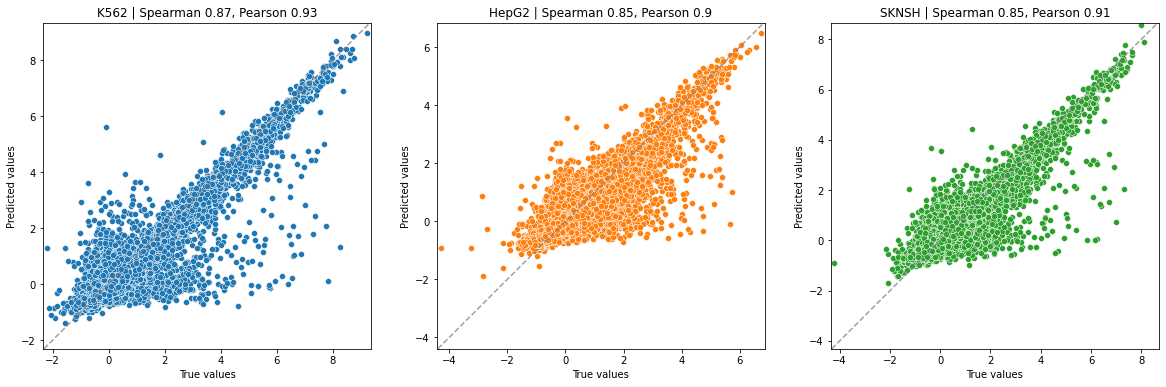

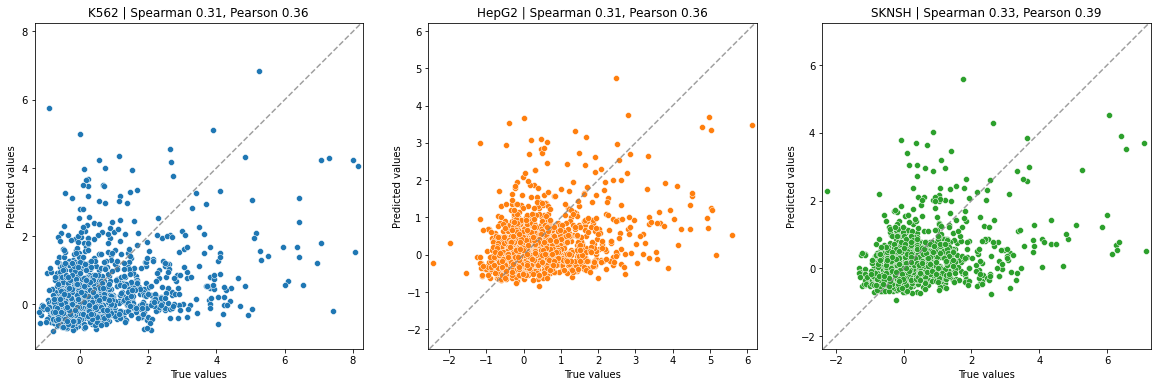

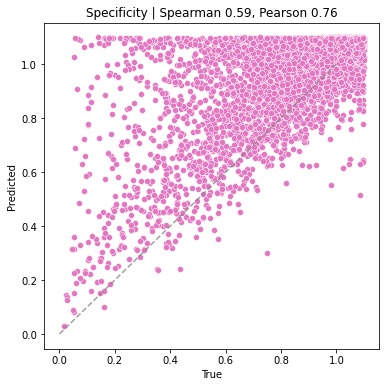

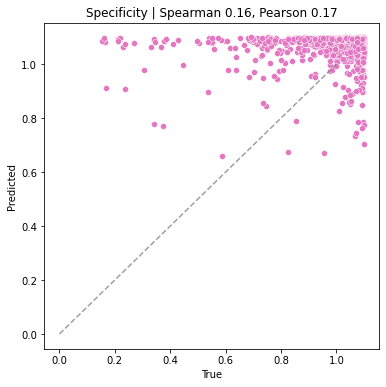

In [18]:
train_truths, train_preds = get_predictions(model, datamodule, dataset='train')
val_truths, val_preds = get_predictions(model, datamodule, dataset='val')
get_scatterplots(train_truths, train_preds)
get_scatterplots(val_truths, val_preds)
get_specificity_corr(torch.tensor(train_truths), torch.tensor(train_preds), specificity_fn=boda.graph.utils.Shannon_entropy)
get_specificity_corr(torch.tensor(val_truths), torch.tensor(val_preds), specificity_fn=boda.graph.utils.Shannon_entropy)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


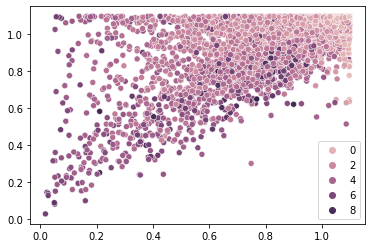

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


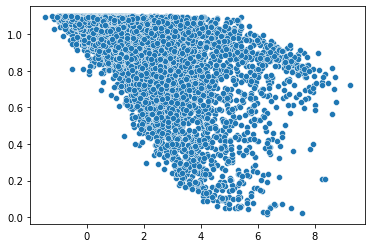

In [19]:
tt_entropy = boda.graph.utils.Shannon_entropy(torch.tensor(train_truths)).numpy()
tp_entropy = boda.graph.utils.Shannon_entropy(torch.tensor(train_preds)).numpy()

sns.scatterplot(tt_entropy, tp_entropy, train_truths.max(axis=1))
plt.show()
sns.scatterplot(train_truths.max(axis=1), tt_entropy)
plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


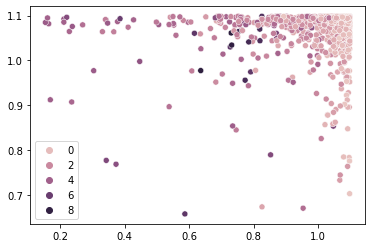

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


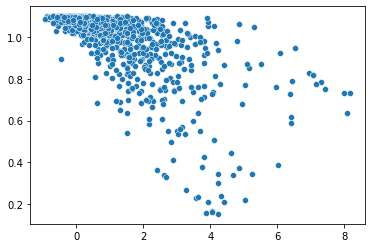

In [20]:
vt_entropy = boda.graph.utils.Shannon_entropy(torch.tensor(val_truths)).numpy()
vp_entropy = boda.graph.utils.Shannon_entropy(torch.tensor(val_preds)).numpy()

sns.scatterplot(vt_entropy, vp_entropy, val_truths.max(axis=1))
plt.show()
sns.scatterplot(val_truths.max(axis=1), vt_entropy)
plt.show()